In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.utils import save_image
from torchvision import datasets, transforms

import numpy as np
import time, os
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Dataset

In [2]:
learning_rate = 2e-4
b_size = 32

data_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.LFWPeople(root="../data/", split="train", transform=data_transform, download=True)   
test_data = datasets.LFWPeople(root="../data/", split="test", transform=data_transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [73]:
print(len(train_data))
print(len(test_data))

9525
3708


In [67]:
class TripletDataset():
    """ Preparing the dataset for triplet loss """
    def __init__(self, dataset_lfw): 
        self.dataset_lfw = dataset_lfw
        self.dataset = []
        
        self.dataset_labels = np.array([label for _,label in dataset_lfw]) 
        
        #get ocurrence of labels in LFW dataset in a dictionary
        ocur_labels = Counter(self.dataset_labels)
        
        #create a subset with faces/images that have more than 1 occurrence in the dataset
        positive_pair_labels = [key for (key, value) in ocur_labels.items() if(value != 1)]
        
        for img, label in dataset_lfw:
            if label in positive_pair_labels: 
                self.dataset.append([img, label])
        
    def __getitem__(self, anchor_idx):
        """Input: Index of anchors that have a positive pair"""
        positive_images = []
        negative_images = []
        anchor_img, anchor_label = self.dataset[anchor_idx] 
        
        #obtain list of images with same and different labels; 
        #searching through the whole dataset to obtain more negatives
        for _, (img, label) in enumerate(self.dataset_lfw):
            if (label != anchor_label):
                negative_images.append([img, label])
            elif(label==anchor_label):
                if not torch.equal(anchor_img, img):
                    positive_images.append([img, label])
                
        #random sample positive and negative pairs from the lists
        positive_img_id = np.random.choice(np.arange(len(positive_images)))
        negative_img_id = np.random.choice(np.arange(len(negative_images)))
          
        positive_img, positive_label = positive_images[positive_img_id]
        negative_img, negative_label = negative_images[negative_img_id]
            
        return (anchor_img, positive_img, negative_img), (anchor_label, positive_label, negative_label)
        
    def __len__(self):
        """Return length of anchor set"""
        return len(self.dataset)

In [68]:
dataset_trainTriplet = TripletDataset(train_data)
dataset_testTriplet = TripletDataset(test_data)


6671


In [41]:
def visualize_data(anchor, positive, negative):
    """Visualize the anchor, its positive and negative"""
  
    images_ = [anchor, positive, negative]
    images_numpy = [image.numpy().transpose(1, 2, 0) for image in images_]
    std = mean = np.array([0.5, 0.5, 0.5])
    images = [(image * std + mean) for image in images_numpy]
    
    fig = plt.figure(figsize=(3*2.5,1*2.5))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(images[i])
        plt.axis("off")
        
    plt.suptitle("Anchor (left), Positive (center) and Negative (right) pairs")
    plt.show()
    

tensor([[[ 0.8510,  0.8510,  0.8510,  ...,  0.8824,  0.8745,  0.8745],
         [ 0.8588,  0.8588,  0.8588,  ...,  0.8745,  0.8824,  0.8824],
         [ 0.8510,  0.8667,  0.8667,  ...,  0.8745,  0.8745,  0.8745],
         ...,
         [-0.7020, -0.6706, -0.6314,  ..., -0.6157, -0.6157, -0.6157],
         [-0.6941, -0.6627, -0.6706,  ..., -0.6157, -0.6157, -0.6157],
         [-0.6863, -0.6784, -0.6941,  ..., -0.6235, -0.6235, -0.6235]],

        [[ 0.8980,  0.8980,  0.8980,  ...,  0.8824,  0.8745,  0.8745],
         [ 0.9059,  0.9059,  0.9059,  ...,  0.8745,  0.8824,  0.8824],
         [ 0.9216,  0.9137,  0.9137,  ...,  0.8745,  0.8745,  0.8745],
         ...,
         [-0.7098, -0.6863, -0.6706,  ..., -0.5294, -0.5294, -0.5294],
         [-0.6706, -0.6549, -0.7020,  ..., -0.5294, -0.5294, -0.5294],
         [-0.6471, -0.6471, -0.6863,  ..., -0.5373, -0.5373, -0.5373]],

        [[ 0.8980,  0.8980,  0.8980,  ...,  0.8824,  0.8745,  0.8745],
         [ 0.9059,  0.9059,  0.9059,  ...,  0

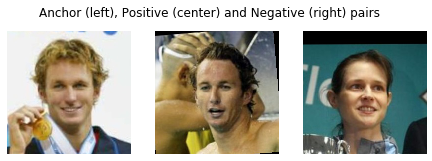

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -0.9843,  ..., -0.9922, -0.9922, -1.0000],
         [-1.0000, -1.0000, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1

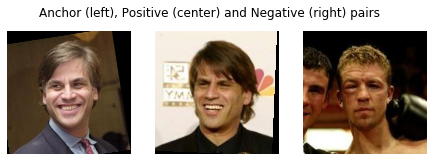

In [42]:
(anchor, pos, neg), (_,_,_) = dataset_trainTriplet[0]
visualize_data(anchor, pos, neg)

(anchor, pos, neg), (_,_,_) = dataset_trainTriplet[5]
visualize_data(anchor, pos, neg)

In [77]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_trainTriplet, batch_size=b_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_testTriplet, batch_size=b_size, shuffle=False)

In [ ]:
print(len(dataset_trainTriplet))
print(len(dataset_testTriplet))

for b_Id, ((anchor, pos, neg), _) in enumerate(tqdm(test_loader)):
    print(b_Id)
    print(anchor.shape)


  0%|          | 0/78 [00:00<?, ?it/s]

6671
2493


# Utils

In [55]:
def save_model(epoch, model, optimizer, test_loss):
    path = savepath(epoch)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'valid_loss': test_loss
    }

    torch.save(checkpoint, path)

def load_model(model, optimizer, epochs):
    for epoch in range(epochs):
        path = savepath(epoch)
        checkpoint = torch.load(path)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        val_loss = checkpoint["valid_loss"]

        return model, optimizer, val_loss

def plot_curves(stats, epochs):
    plt.style.use("seaborn")
    fig, ax = plt.subplots(2)

    epochs = np.arange(epochs)
    ax[0].plot(epochs, stats["discriminator_loss"], c="green", label="Discriminator loss")
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")

    ax[1].plot(epochs, stats["generator_loss"], c="blue", label="Generator loss")
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    fig.suptitle("Models Loss Curves")

    fig.savefig("loss_curves.png", dpi=300)
    plt.show()


def count_model_parameters(parameters):
    sum_=0
    for param in parameters:
        sum_+= param.numel()
    
    return sum_
        

# Siamese Model

In [13]:
class SiameseNet(nn.Module):
    def __init__(self, hidden_size = [4, 32, 128, 512], b_size=64):
        super().__init__()
        
        net_conv = []
        
        net_conv.append(nn.Conv2d(in_channels=3, out_channels=hidden_size[0], kernel_size=3, padding=1))
        net_conv.append(nn.BatchNorm2d(hidden_size[0]))
        net_conv.append(nn.ReLU(inplace=True))
        
        for i in range(len(hidden_size)-1):              
            net_conv.append(nn.Conv2d(in_channels=hidden_size[i], out_channels=2*hidden_size[i], kernel_size=3, padding=1))
            net_conv.append(nn.BatchNorm2d(2*hidden_size[i]))
            net_conv.append(nn.ReLU(inplace=True))

            net_conv.append(nn.Conv2d(in_channels=2*hidden_size[i], out_channels=hidden_size[i+1], kernel_size=3,padding=1))
            net_conv.append(nn.BatchNorm2d(hidden_size[i+1]))
            net_conv.append(nn.ReLU(inplace=True))
            net_conv.append(nn.MaxPool2d(kernel_size=2, stride=2))                
        #output size: 2048x31x31
        
        self.net_conv = nn.Sequential(*net_conv)
        
        num_features = hidden_size[-1] * 31 * 31
        
        self.net_fc = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=4096, bias=False), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.3),
            nn.Linear(in_features=4096, out_features=128) 
        )
        
        self.flatten = nn.Flatten()   
                            
    def forward_once(self, input_img):
        emb_conv = self.net_conv(input_img)
        emb_fc = self.net_fc(self.flatten(emb_conv))
        #Normalize the embedding with its L2 norm
        emb_norm = emb_fc/torch.norm(emb_fc, p=2, dim=-1, keepdim=True)
        
        return emb_norm
    
    def forward(self, anchor, positive, negative):
        anchor_emb = self.forward_once(anchor)
        positive_emb = self.forward_once(positive)
        negative_emb = self.forward_once(negative)
        
        return anchor_emb, positive_emb, negative_emb
    

In [14]:
model = SiameseNet()

In [15]:
print(count_model_parameters(model.parameters()))
model

2017459920


SiameseNet(
  (net_conv): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05,

# Training


In [26]:
class TripletLoss(nn.Module):
    """Implementation of the triplet loss function"""
    def __init__(self):
        super().__init__()
        
    def computeLoss(self, anchor, positive, negative, margin=0.3):
        
        #Euclidean distances
        d_AP = (anchor - positive).pow(2).sum(dim=-1)
        d_AN = (anchor - negative).pow(2).sum(dim=-1)
        
        #triplet loss
        loss = torch.maximum(d_AP - d_AN + margin, torch.zeros_like(d_AP))
        
        return torch.mean(loss)
        
        

In [ ]:
loss = TripletLoss()
input_tensor_anchor = torch.ones([b_size, 3, 250, 250])
input_tensor_positive = torch.ones([b_size, 3, 250, 250])
input_tensor_negative = torch.zeros([b_size, 3, 250, 250])
loss.computeLoss(input_tensor_anchor, input_tensor_positive, input_tensor_negative)

In [51]:
"""Setup model"""
model = SiameseNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), learning_rate)
lossFunction = TripletLoss()

In [59]:
class Trainer():
    def __init__(self, model, optimizer):
        
        self.optimizer = optimizer
        self.model = model
        self.epochs = 100

        self.stats = {
            "train_loss": [],
            "test_loss": []
        }
        

    
    def train_model(self):
        self.train_loss = []
        self.test_loss = []
        
        print(len(dataset_trainTriplet))
            
        for epoch in range(self.epochs):
            start_training_time = time.time()
            print(f"--------------EPOCH {epoch}--------------")

            images_train, reconstructions_train = self.train_epoch()
            self.output_images_train.append((epoch, images_train, reconstructions_train),)
            print(f"Training loss: {self.train_loss[-1]}, training time: {time.time() - start_training_time}")

            images_test, reconstructions_test = self.test_epoch(epoch)
            self.output_images_test.append((epoch, images_test, reconstructions_test),)
            print(f"Testing loss: {self.test_loss[-1]}")

            self.stats["train_loss"].append(self.train_loss[-1])
            self.stats["test_loss"].append(self.test_loss[-1])
            save_model(epoch, self.model, self.optimizer, self.test_loss[-1])

        plot_curves(stats=self.stats, epochs=EPOCHS)

        return

    def train_epoch(self):
        train_losses = []
        self.model.train()

        for idx in range(len(dataset_trainTriplet)):
            print(idx)
            anchor, positive, negative = dataset_trainTriplet[idx]
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            self.optimizer.zero_grad()
            
            out_anchor, out_positive, out_negative = self.model(anchor, positive, negative)
            
            loss = lossFunction.computeLoss(out_anchor, out_positive, out_negative)
            loss.backward()
            train_losses.append(loss.item())

            self.optimizer.step()

        self.train_loss.append(np.mean(train_losses))

        return 

    @torch.no_grad()
    def test_epoch(self, epoch):
        test_losses = []

        for idx in range(len(dataset_testTriplet)):
            anchor, positive, negative = dataset_testTriplet[idx]
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            out_anchor, out_positive, out_negative = self.model(anchor, positive, negative)
            loss = lossFunction.computeLoss(out_anchor, out_positive, out_negative)

        self.test_loss.append(np.mean(test_losses))
        
        return 

In [60]:
train = Trainer(model, optimizer)
train.train_model()

9525
--------------EPOCH 0--------------
0


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [4, 3, 3, 3], but got 3-dimensional input of size [3, 250, 250] instead